In [1]:
import random 
import numpy as np
from collections import defaultdict
from tqdm import tqdm  # For iteration printout
import gym             # For openAI gym environments
from gym import envs

# From my own personal lib
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib import plotting
from lib.envs.blackjack import BlackjackEnv

In [2]:
# If using open AI GYM
# print(envs.registry.all()) # Available environments https://gym.openai.com/envs/#toy_text 
env = gym.make('Blackjack-v0')

state = env.reset()
action = env.action_space.sample()
print(env.action_space.n)    # 2 
print(env.observation_space) # Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
#help(env.unwrapped)

2
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [3]:
# But we are using our personal library instead
env = BlackjackEnv()

In [4]:
# Policy definitions
# Behavior, target, epsilon decay Definition
# Epsilon Decay per episode.
def update_epsilon(current_episode, max_episodes, initial_e = 1.0, final_e = 0.0):
    r = max((max_episodes-current_episode)/max_episodes,0)
    e = (initial_e-final_e)*r + final_e
    return e

# Behaviour policy : To get all possible action
def epsilon_policy(target_policy,Q,epsilon,available_actions):
    '''
    My previous conception of policy is wrong. It should be a distribution of 
    state -> actions distributions
    
    My conception of the policy is that target policy is encapsulated within the behavior policy.
    
    The benefit of this returning a function within a function is that
    we can store Q within the function policy_fn(state).
    When all episodes are completed.
    '''
    def policy_fn(state): # TODO: Store this function 
        n = random.random()
        if n < epsilon:
            actions_distribution = np.ones(available_actions, dtype=float) / available_actions            
        else:
            actions_distribution = np.zeros_like(Q[state],dtype=float)
            best_action = target_policy(Q[state])
            actions_distribution[best_action] = 1.0
        return actions_distribution
    return policy_fn

# Target Policy : Choose best action from Q
def greedy_policy(Q):
    return np.argmax(Q)

In [5]:
# Policy demonstration
# Deterministic
epsilon = 0
policy = epsilon_policy(greedy_policy,[[3.1,1.1,2,0]],epsilon,available_actions = 4)
print('Deterministic', policy(0))

# Exploratory
epsilon = 1
policy = epsilon_policy(greedy_policy,[[3.1,1.1,2,0]],epsilon,available_actions = 4)
print('Exploratory', policy(0))
# policy outputs the distribution of actions at the given state.

Deterministic [1. 0. 0. 0.]
Exploratory [0.25 0.25 0.25 0.25]


In [6]:
# defaultdict demonstation
# in case anybody don't know
Q = defaultdict(lambda:np.zeros(env.action_space.n))
Q[0][0]=2
Q[1][1]=3
print(Q)

defaultdict(<function <lambda> at 0x0000022CD9FDA670>, {0: array([2., 0.]), 1: array([0., 3.])})


In [7]:
def monte_carlo_es(env, num_episodes, behavior_policy, discount_factor=1.0, initial_epsilon = 1.0):
    # Init for whole monte-carlo
    '''
    Q = Action value at state[s] for action[a]
    C = Weighted importance samplin - Basically N , number of times the particular [state][action] has
    been visited, so we could calculate the mean.
    '''
    Q = defaultdict(lambda:np.zeros(env.action_space.n))
    C = defaultdict(lambda:np.zeros(env.action_space.n))
    gamma = discount_factor
    
    for ep in tqdm(range(num_episodes)):
        '''
        Changes epsilon(Exploratory). As ep approaches Max Episodes, the policy becomes more deterministic
        Rather than following a random action space when state is given.
        '''
        target_policy = greedy_policy
        epsilon = update_epsilon(ep, num_episodes, initial_e = initial_epsilon, final_e = 0.0)
        policy = epsilon_policy(target_policy,Q,epsilon,env.action_space.n)
        G = 0 # Expected return
        W = 1 
        episode = [] # Store state and reward to be computed after each episode completes/each game_over.
        state = env.reset()
        #print(ep,epsilon)
        while True:
            action = np.random.choice(np.arange(env.action_space.n), p=policy(state))
            next_state, reward, game_over, info = env.step(action)
            episode.append((state, action, reward))
            
            state = next_state
            if game_over:
                break
        for idx, step in enumerate(episode[::-1]):
            state, action, reward = step[0],step[1],step[2] 
            G = gamma*G + reward
            C[state][action] += W
            Q[state][action] += (W/C[state][action])*(G - Q[state][action])
            if action != target_policy(Q[state]):
                break
            else:
                W *= (1/policy(state)[action])
            #print(W,policy(state)[action], epsilon)
    return Q , policy

In [8]:
Q, policy = monte_carlo_es(env, num_episodes=500000, behavior_policy=epsilon_policy, initial_epsilon=0.3)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:28<00:00, 5680.05it/s]


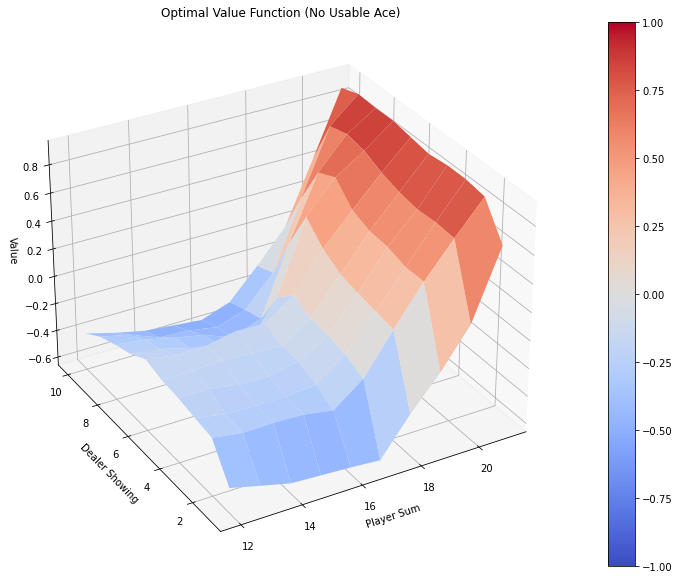

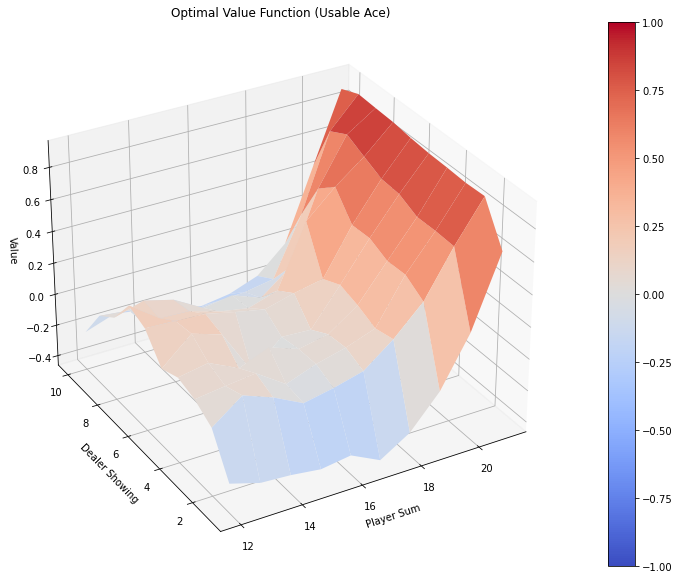

In [10]:
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [11]:
# Reason we don't use the Open AI environment
Q, policy = monte_carlo_es(gym.make('Blackjack-v0'), num_episodes=500000, behavior_policy=epsilon_policy, initial_epsilon=0.3)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:22<00:00, 6042.68it/s]


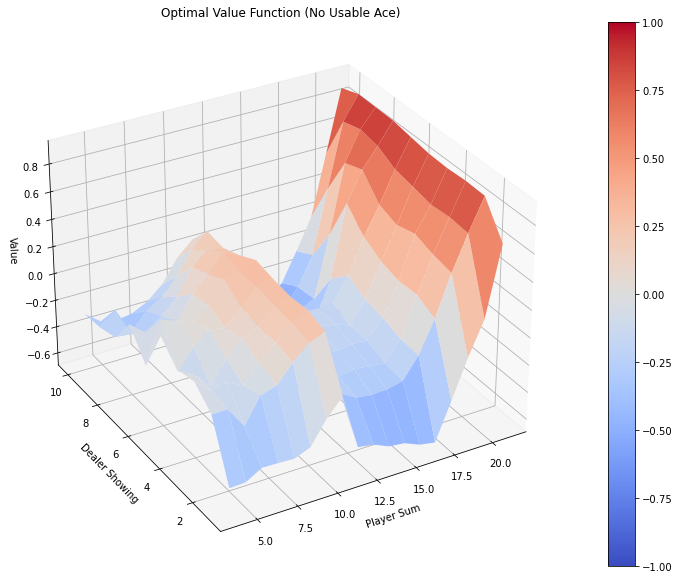

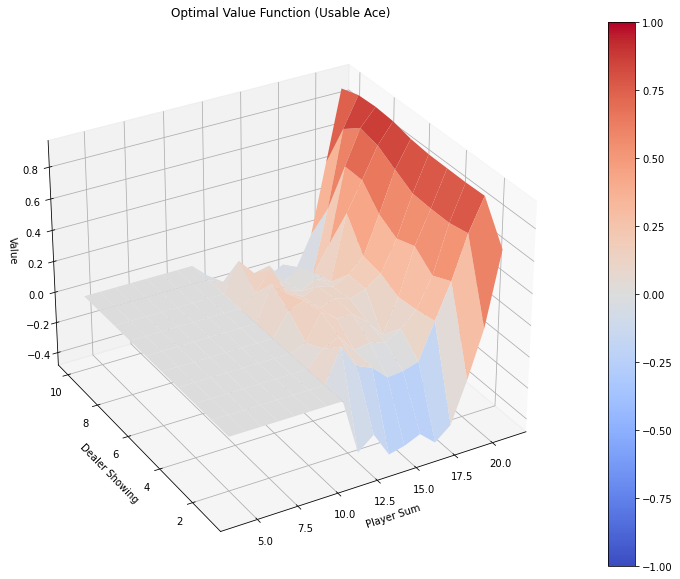

In [12]:
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

### Understanding the Graph
One could speculate that the reason we get Value(0.0) at such states is because we don't really know what's the next card going to be. Or maybe the reward function is not conditioned to 5 cards and we get triple the reward that kinda thing. For what i do know is that we should have more value when we are at a low sum for 2 cards since we might get a triple by the end of taking 5 cards